In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

#ml model
from sklearn.svm import SVC

In [2]:
#data reading
sampledf = pd.read_csv('/Task 3 prodigy internship/sampleSubmission.csv')
traindf = '/Task 3 prodigy internship/train'
testdf = '/Task 3 prodigy internship/test1'

In [6]:
image_size = 64  #resize images 
num_samples_per_class = 3000  #num of samples per class 

In [7]:
#load and preprocess images
def load_data(folder):
    images = []
    labels = []
    filenames = []
    
    #a list of all filenames in the directory
    all_filenames = os.listdir(folder)
    random.shuffle(all_filenames)  #shuffle the filenames

    cats_loaded = 0
    dogs_loaded = 0
    for filename in all_filenames:
        if 'cat' in filename:
            if cats_loaded >= num_samples_per_class:
                continue
            label = 0
            cats_loaded += 1
        elif 'dog' in filename:
            if dogs_loaded >= num_samples_per_class:
                continue
            label = 1
            dogs_loaded += 1
        else:
            continue

        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to grayscale
        images.append(img)
        labels.append(label)
        filenames.append(filename)

        #stop if both classes have enough samples
        if cats_loaded >= num_samples_per_class and dogs_loaded >= num_samples_per_class:
            break

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, filenames


In [24]:
train_images, train_labels, filenames = load_data(traindf)
print(f"Loaded {len(train_images)} training images")

Loaded 6000 training images


In [9]:
#normalizing the images
train_images = train_images / 255.0

In [11]:
#flatten images for SVM
#train_images_flattened = train_images.reshape(train_images.shape[0], -1)

In [25]:
#split into training and validation sets
x_train, x_val, y_train, y_val, train_filenames, val_filenames = train_test_split(train_images, train_labels,filenames, test_size=0.2, random_state=42)

In [13]:
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_val_flattened = x_val.reshape(x_val.shape[0], -1)

In [14]:
#standardizing features
scaler = StandardScaler()
x_train_flattened = scaler.fit_transform(x_train_flattened)
x_val_flattened = scaler.transform(x_val_flattened)

In [15]:
#using pca for dimensionality reduction
pca = PCA(n_components=100)  #number of components
x_train_pca = pca.fit_transform(x_train_flattened)
x_val_pca = pca.transform(x_val_flattened)

In [16]:
#training the SVM model
svm = SVC(kernel='linear', random_state=42)

In [17]:
svm.fit(x_train_pca, y_train)

SVC(kernel='linear', random_state=42)

In [18]:
#model evaluation
y_pred = svm.predict(x_val_pca)

In [19]:
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

Validation Accuracy: 0.57


In [20]:
#classification report
print(classification_report(y_val, y_pred, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.58      0.57      0.58       604
         Dog       0.57      0.58      0.57       596

    accuracy                           0.57      1200
   macro avg       0.57      0.58      0.57      1200
weighted avg       0.58      0.57      0.58      1200



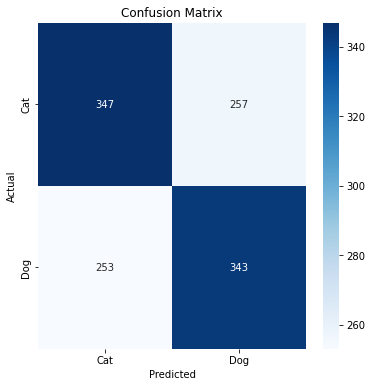

In [21]:
#confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
#a df with filenames and predicted labels
results = pd.DataFrame({
    'id': val_filenames,
    'label': y_pred
})

In [27]:
print(results)

                 id  label
0     dog.10560.jpg      0
1      dog.1348.jpg      1
2      cat.5378.jpg      0
3       cat.723.jpg      0
4      cat.4862.jpg      1
...             ...    ...
1195    dog.442.jpg      1
1196   dog.7060.jpg      0
1197   dog.1480.jpg      1
1198   cat.4271.jpg      0
1199   dog.2339.jpg      0

[1200 rows x 2 columns]


In [28]:
#predicting on test data
def preprocess_test_images(directory):
    test_images = []
    test_filenames = []
    
    all_filenames = os.listdir(directory)
    for filename in all_filenames:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to grayscale
            test_images.append(img)
            test_filenames.append(filename)
    
    test_images = np.array(test_images)
    return test_images, test_filenames

In [32]:
#loading and preprocess test images
test_images, test_filenames = preprocess_test_images(testdf)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

In [33]:
test_images_pca = pca.transform(test_images_flattened)

In [34]:
#prediction
test_predictions = svm.predict(test_images_pca)
print(f'Number of test predictions: {len(test_predictions)}')

Number of test predictions: 12500


In [35]:
#test accuracy
#simulating actual labels since test data doesn't provide labels
#assuming an equal distribution of labels for demonstration
y_test_simulated = np.array([0] * (len(test_images) // 2) + [1] * (len(test_images) // 2))
accuracy_test = accuracy_score(y_test_simulated, test_predictions)
print(f'Test Accuracy: {accuracy_test:.2f}')

Test Accuracy: 0.50


In [36]:
print(classification_report(y_test_simulated, test_predictions, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.50      0.38      0.43      6250
         Dog       0.50      0.62      0.56      6250

    accuracy                           0.50     12500
   macro avg       0.50      0.50      0.49     12500
weighted avg       0.50      0.50      0.49     12500



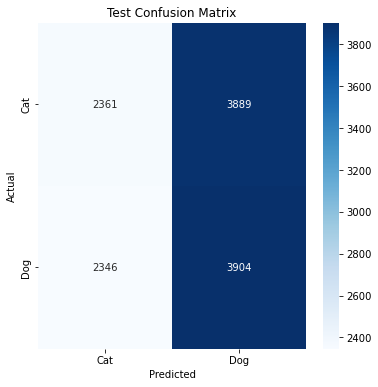

In [37]:
#confusion matrix for test data
cm_test = confusion_matrix(y_test_simulated, test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

In [38]:
#func to manually test an image
def test_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to grayscale
    img_flattened = img.reshape(1, -1)  #flatten the image
    img_pca = pca.transform(img_flattened)  #applying PCA transformation
    prediction = svm.predict(img_pca)
    label = 'Dog' if prediction[0] == 1 else 'Cat'
    
    #displaying the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Label: {label}')
    plt.axis('off')
    plt.show()
    
    return label

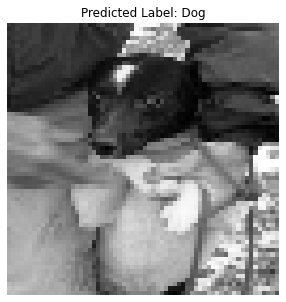

The predicted label for the selected image is: Dog


In [40]:
test_image_path = os.path.join(testdf, test_filenames[0])  #the first file from the test list
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

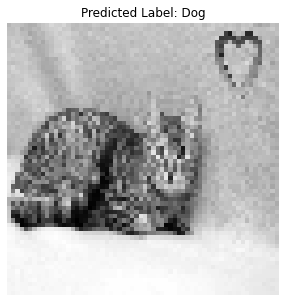

The predicted label for the selected image is: Dog


In [41]:
test_image_path = '/Task 3 prodigy internship/test1/237.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

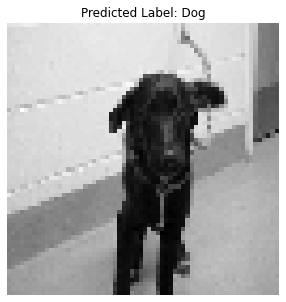

The predicted label for the selected image is: Dog


In [42]:
test_image_path = '/Task 3 prodigy internship/test1/9000.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

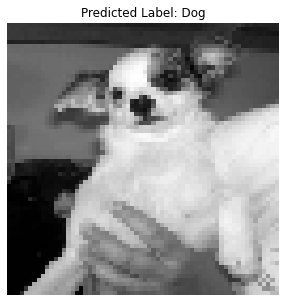

The predicted label for the selected image is: Dog


In [43]:
test_image_path = '/Task 3 prodigy internship/test1/3000.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

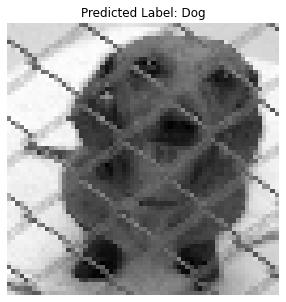

The predicted label for the selected image is: Dog


In [44]:
test_image_path = '/Task 3 prodigy internship/test1/700.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

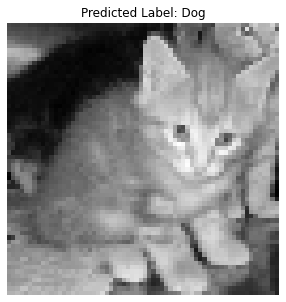

The predicted label for the selected image is: Dog


In [45]:
test_image_path = '/Task 3 prodigy internship/test1/448.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

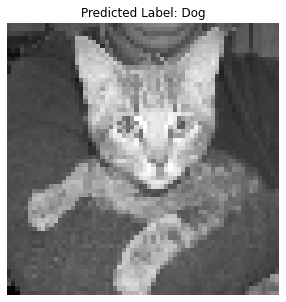

The predicted label for the selected image is: Dog


In [47]:
test_image_path = '/Task 3 prodigy internship/test1/621.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

In [49]:
def display_sample_test_images(test_images, test_filenames, sample_count=6):
    indices = np.random.choice(len(test_images), sample_count, replace=False)
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        img = test_images[idx]
        img_flattened = img.reshape(1, -1)
        img_pca = pca.transform(img_flattened)
        prediction = svm.predict(img_pca)
        label = 'Dog' if prediction[0] == 1 else 'Cat'
        
        plt.subplot(2, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Predicted Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

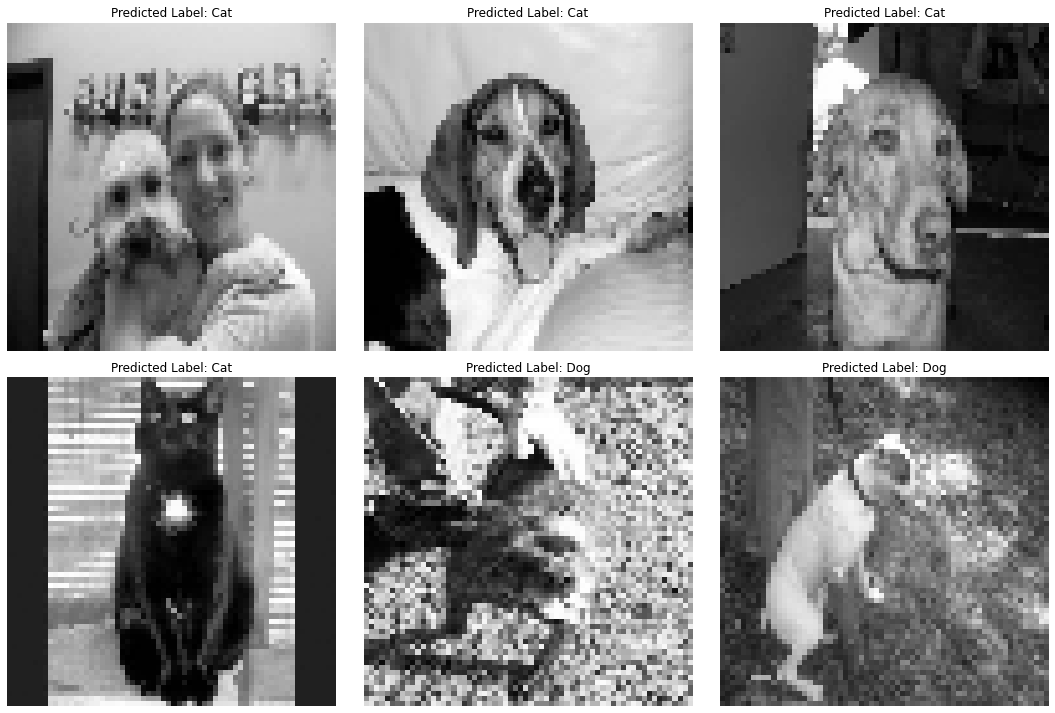

In [50]:
display_sample_test_images(test_images, test_filenames)

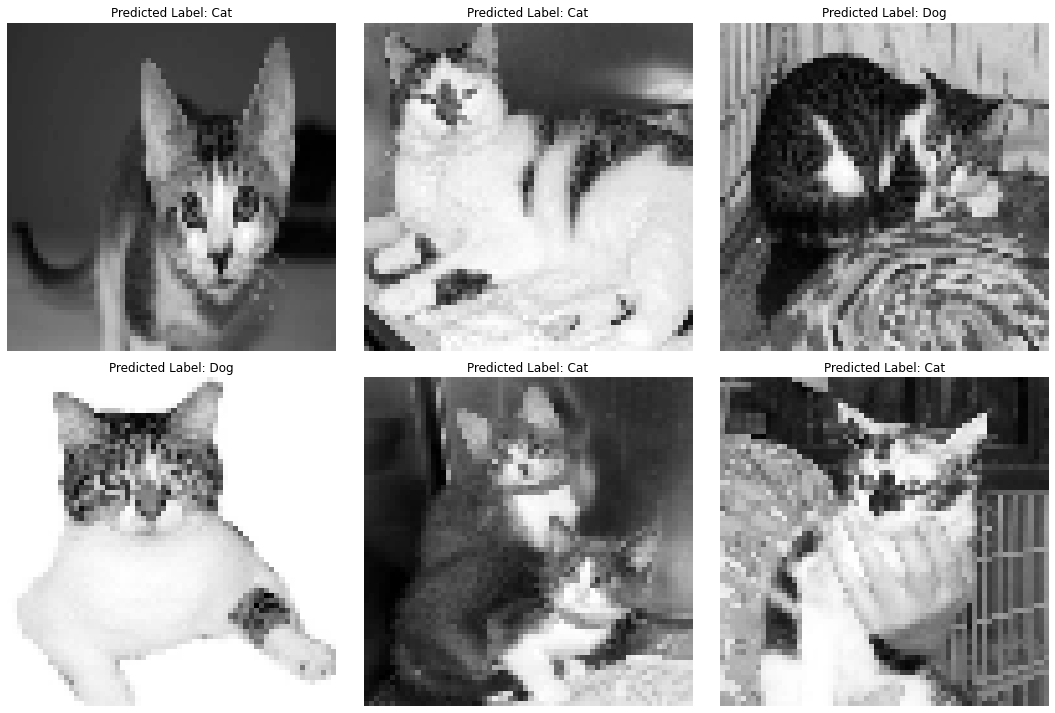

In [52]:
display_sample_test_images(test_images, test_filenames)